<a href="https://colab.research.google.com/github/notiona/dacon_know/blob/main/hyobae/multiinput_modeling_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/Dacon/dacon_know
%cd hyobae
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dacon/dacon_know
/content/drive/MyDrive/Dacon/dacon_know/hyobae


'/content/drive/MyDrive/Dacon/dacon_know/hyobae'

In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D,BatchNormalization
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm
import warnings

RANDOM_STATE = 42
np.seed = 42
DATA_PATH = "../data_0116/"

warnings.filterwarnings(action='ignore')
PATH_2017 = DATA_PATH + "train/KNOW_2017.csv"
PATH_2018 = DATA_PATH + "train/KNOW_2018.csv"
PATH_2019 = DATA_PATH + "train/KNOW_2019.csv"
PATH_2020 = DATA_PATH + "train/KNOW_2020.csv"

paths = [PATH_2017, PATH_2018, PATH_2019, PATH_2020]

know_train = [pd.read_csv(path) for path in paths]

TEST_PATH_2017 = DATA_PATH + "test/KNOW_2017_test.csv"
TEST_PATH_2018 = DATA_PATH + "test/KNOW_2018_test.csv"
TEST_PATH_2019 = DATA_PATH + "test/KNOW_2019_test.csv"
TEST_PATH_2020 = DATA_PATH + "test/KNOW_2020_test.csv"

TEST_PATHs = [TEST_PATH_2017, TEST_PATH_2018, TEST_PATH_2019, TEST_PATH_2020]
know_test = [pd.read_csv(path) for path in TEST_PATHs]

In [4]:
# doc2vec을 사용할거라 txt열을 모두 하나로 모아줘야해요
text_info_cols = {"2017": ['sim_job','bef_job','able_job','major'],
                  "2018": ['sim_job','bef_job','able_job','major'],
                  "2019": ['bef_job','able_job','major'],
                  "2020": ['major'],}
years = ['2017','2018','2019','2020']

for i, year in enumerate(years):
    text_info_col = text_info_cols[year]
    for col in text_info_col:
        know_train[i]['text_response'] = know_train[i]['text_response'] + ' ' + know_train[i][col]
        know_test[i]['text_response'] = know_test[i]['text_response'] + ' ' + know_test[i][col]
    know_train[i].drop(text_info_col,axis=1, inplace=True)
    know_test[i].drop(text_info_col,axis=1, inplace=True)

# text_response 내 존재하는 stopwords들을 제거해줍시다
stopwords = ['없다','없음','0','모름','공란']
for i in tqdm(range(4)):
    for k, doc in enumerate(know_train[i]['text_response']):
        doc_list = doc.split(' ')
        new_list = [word for word in doc_list if word not in stopwords]
        new_string = ''
        for word in new_list:
            new_string += word
            new_string += ' '
        know_train[i].loc[k,'text_response'] = new_string[:-1]
    for k, doc in enumerate(know_test[i]['text_response']):
        doc_list = doc.split(' ')
        new_list = [word for word in doc_list if word not in stopwords]
        new_string = ''
        for word in new_list:
            new_string += word
            new_string += ' '
        know_test[i].loc[k,'text_response'] = new_string[:-1]

# description은 드랍합시다
for i in range(4):
    know_train[i].drop('description',axis=1,inplace=True)

100%|██████████| 4/4 [00:48<00:00, 12.21s/it]


In [5]:
# 일단은 2017년으로 해봅시다

data = know_train[0]

from sklearn import preprocessing

# 딥러닝 모델에 돌리려면 target 값을 label encoding을 해주어야 합니다. 

X = data.drop(['idx','knowcode'],axis=1)
y = data['knowcode']

label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

# train이랑 validation set을 나눠서 해보죠
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# 이 부분은 반드시 해줘야 합니다! 마지막 softmax에서 다중분류로 인식하기 위해서 필요해요
len_output = len(np.unique(y_train))

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [6]:
X_train

,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,aq5_2,aq6_1,aq6_2,aq7_1,aq7_2,aq8_1,aq8_2,aq9_1,aq9_2,aq10_1,aq10_2,aq11_1,aq11_2,aq12_1,aq12_2,aq13_1,aq13_2,aq14_1,aq14_2,aq15_1,aq15_2,aq16_1,aq16_2,aq17_1,aq17_2,aq18_1,aq18_2,aq19_1,aq19_2,aq20_1,aq20_2,...,bq18_1,bq18_2,bq18_3,bq18_4,bq18_5,bq18_6,bq18_7,bq19,bq20,bq21,bq22,bq23,bq24_1,bq24_2,bq24_3,bq24_4,bq24_5,bq24_6,bq24_7,bq24_8,bq25,bq26,bq27,bq28,bq29,bq35,bq36,bq37,bq38,bq39_1,bq39_2,bq40,bq41_1,bq41_2,bq41_3,text_response,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
3405,3,4,4,5,4,5,1,0,1,0,3,3,1,0,3,3,3,3,2,2,5,6,3,4,3,3,4,5,4,5,5,6,1,0,1,0,1,0,1,0,...,4,4,5,5,4,2,4,3,2,3,3,40,2,2,2,2,2,2,2,2,3,3,4,4,3,4,2,33,4,1,1,1,4000,0,2500,저출산 인구 감소 여가 생활 활성화 수요 증가 무용 음악 음향 시설 비디오 베가스 ...,0,0,0,0
7841,1,0,1,0,1,0,2,3,3,4,1,0,1,0,1,0,2,3,2,2,1,0,1,0,3,3,3,5,2,1,2,3,2,3,1,0,1,0,1,0,...,2,4,3,2,3,3,3,3,2,3,1,10,2,2,2,2,2,2,2,2,4,4,4,3,2,3,2,39,4,1,1,1,2900,0,2400,청소년지도사 청소년 문제 급증 선생님 학생 행정학,1,0,0,0
7608,5,7,5,7,5,7,1,0,1,0,5,7,5,7,5,7,5,7,5,7,5,7,5,7,5,7,5,7,5,7,2,2,1,0,1,0,5,7,1,0,...,4,3,3,3,4,3,3,1,4,1,2,30,2,1,1,2,2,2,2,2,4,3,3,3,3,4,1,55,5,1,1,1,7500,0,5000,교사 교장 자격증 학교관리에 필요한 업무 학생 감소 컴퓨터 선생님 교사 국어국문학,0,0,0,0
533,3,4,3,4,4,5,1,0,3,4,4,5,1,0,2,3,4,5,4,5,3,4,2,2,3,4,3,4,4,5,1,0,1,0,1,0,3,4,1,0,...,3,4,2,2,2,2,3,4,2,3,1,26,2,2,2,2,2,2,2,2,4,4,3,3,2,3,2,30,4,1,1,1,2800,0,2000,여가 대한 관심 컴퓨터 문서교정원 국어국문학,0,0,0,0
473,2,3,3,4,2,3,3,5,4,5,2,4,2,4,2,4,3,4,2,4,2,3,3,4,3,4,2,4,2,4,2,4,5,5,5,6,3,4,2,4,...,2,3,2,2,3,2,2,3,2,3,1,20,2,2,2,2,2,2,2,2,4,4,3,3,2,3,1,58,2,1,1,1,3300,0,1600,필요 때문 단기 곡기 건설노동자 인문계,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,4,6,4,6,4,6,1,0,4,5,4,6,4,6,4,6,4,6,4,6,4,6,4,6,4,5,4,6,4,6,1,0,1,0,1,0,5,7,1,0,...,3,3,3,3,4,4,4,1,3,1,2,50,2,1,2,2,2,2,2,2,3,3,4,4,3,4,1,59,3,1,1,1,4500,0,2300,무역사무에 대한 프로세스 교육 현재 수출입 통관 절차 전국구 점점 지역 일자리 현재...,0,0,0,0
5191,4,5,4,5,4,5,1,0,4,5,4,5,4,4,4,5,4,5,5,6,4,4,5,6,3,5,4,5,5,6,4,5,3,4,5,6,4,6,4,4,...,3,3,2,2,2,2,3,3,3,3,5,70,1,1,1,1,1,2,2,2,4,5,5,5,2,3,1,32,6,1,1,1,5500,0,4000,원자력 대한 안전 문제 계산 프로그램 엑셀 연구원 원자력공학,0,0,0,0
5390,4,6,5,6,4,5,3,4,4,5,4,5,4,5,4,6,4,5,4,5,1,0,3,3,4,5,1,0,4,5,2,2,4,5,2,2,4,5,1,0,...,3,4,2,2,2,3,3,3,2,3,1,2,1,1,1,2,2,2,2,2,4,4,3,4,3,2,2,29,6,1,1,1,3200,0,2800,일상생활 컴퓨터 생물학,1,0,0,0
860,4,5,5,6,4,6,3,1,3,4,4,6,3,5,3,7,3,6,4,6,2,5,3,5,4,4,3,4,3,4,1,0,1,0,2,1,4,5,1,0,...,4,2,3,4,4,1,2,3,3,4,5,5,2,2,2,2,1,2,2,2,3,4,3,3,2,3,2,33,5,1,2,2,1300,0,1300,"상담심리사 상담수련 슈퍼비젼 상태 유지 녹음기 상담심리사,심리치료사 진로상담,청소년...",0,0,0,0


# FastText

In [7]:
from gensim.models import FastText

In [8]:
# build corpus
corpus = []

for i in range(4):
    for sen in know_train[i]['text_response']:
        corpus.append(sen.split())

len(corpus)

35235

In [9]:
corpus[:10]

[['자동차도장기능사', '실무교육', '생산', '설비', '자동화', '건설현장', '노무직', '실업'],
 ['건축전기설비기술사', '건설', '수주', '드라이버', '가위', '건축공학'],
 ['건축전기설비기술사', '신축', '건설', '경기', '건축', '설계', '오토캐드', '파이프', '보일러', '건축공학'],
 ['지적기사',
  '측량',
  '정보통신기술',
  '교육',
  '무량',
  '감소',
  '자동화',
  '토탈',
  '스테이션',
  '지적기사',
  '무',
  '지적공무원',
  '환경학과'],
 ['건축전기설비기술사',
  '부동산',
  '거품',
  '건축',
  '경기도',
  '덩달아',
  '불황',
  '캐드',
  '엑셀',
  '건축',
  '도면',
  '건축공학'],
 ['다양한', '업무파악', '전문', '직업', '볼펜', '안내원', '경제학'],
 ['자유로운', '근무조건', '근무', '컴퓨터', '볼펜', '안내원', '컴퓨터학'],
 ['도장기능사', '자동화', '퍼티', '프라이머', '페이스', '스틱', '프라이머', '학생(없다)', '자동화'],
 ['항공교통관제사',
  '항공교통관제관련교육',
  '인공',
  '지능',
  '자동화',
  '관제',
  '관련',
  '시스템',
  '관제사',
  '관제사(동일함)',
  '운항관리사',
  '전자공학'],
 ['충전시설관리',
  '위험관리사',
  '현장적응기간',
  '위험물취급메뉴얼숙지',
  '가스',
  '사용',
  '가스',
  '충전기',
  '위험',
  '취급',
  '메뉴얼',
  '측정기',
  '가스안전관리사',
  '상고']]

In [10]:
# ref: https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py

word_dim = 20
ftmodel = FastText(size=word_dim, window=5)
ftmodel.build_vocab(sentences = corpus)
ftmodel.train(
    sentences = corpus, epochs=ftmodel.epochs,
    total_examples=ftmodel.corpus_count, total_words=ftmodel.corpus_total_words
)

In [11]:
ftmodel.wv.vectors.shape

(6568, 20)

### vector 테스트

In [12]:
ftmodel.wv.most_similar('건축', topn=10)

[('건축가', 0.991499662399292),
 ('건축업', 0.9880428314208984),
 ('건축사', 0.9862849116325378),
 ('건축과', 0.9855365753173828),
 ('건축시공', 0.9808871746063232),
 ('건축물', 0.9803171753883362),
 ('건축감리', 0.979778528213501),
 ('건축학', 0.9718727469444275),
 ('건설', 0.9677588939666748),
 ('토목', 0.966839075088501)]

In [13]:
ftmodel.wv.most_similar('현장', topn=10)

[('건설안전기사', 0.9832208156585693),
 ('건설재료시험기사', 0.9794289469718933),
 ('건설기사', 0.9773077964782715),
 ('건설기계기사', 0.9761372804641724),
 ('건설중기정비', 0.970638632774353),
 ('건설재료시험기능사', 0.9705491662025452),
 ('건설기계정비', 0.9692701697349548),
 ('건설기계산업기사', 0.969080924987793),
 ('건설기계정비사', 0.9676591157913208),
 ('건설안전산업기사', 0.9663099646568298)]

In [14]:
ftmodel.wv.most_similar('디자인', topn=10)

[('디자인툴', 0.9949970841407776),
 ('디자인과', 0.9760379791259766),
 ('웹디자인', 0.9738892912864685),
 ('색채디자인', 0.9696640372276306),
 ('편집디자인', 0.96122145652771),
 ('공간디자인', 0.9608163833618164),
 ('시각정보디자인', 0.9603166580200195),
 ('디자이너', 0.9579256176948547),
 ('디자이너,', 0.9554184675216675),
 ('섬유디자인', 0.9551846981048584)]

In [15]:
ftmodel.wv.most_similar('컴퓨터', topn=10)

[('컴퓨터를', 0.9702941179275513),
 ('컴퓨터에', 0.9668456315994263),
 ('컴퓨터과', 0.9664496779441833),
 ('컴퓨터활용', 0.9594507217407227),
 ('컴퓨터학', 0.9531933665275574),
 ('컴퓨터학과', 0.9522439241409302),
 ('컴퓨터정보과', 0.9513859152793884),
 ('컴퓨터활용능력', 0.9495775103569031),
 ('컴퓨터과학', 0.9481323957443237),
 ('컨설턴트', 0.9465728998184204)]

# Deep Modeling

In [16]:
def sen_to_seq(s_list): # s = ['ㅇㅣ_ㅎㅛ_ㅂㅐ_', 'ㅂㅏ_ㅂㅗ_']
    seq = list()
    for s in s_list:
        try:
            seq_value = ftmodel.wv.index2word.index(s)+1
        except:
            seq_value = 0 # 없으면 0
        seq.append(seq_value)
    return seq

In [17]:
know_train[0]['text_response'].iloc[0].split()

['자동차도장기능사', '실무교육', '생산', '설비', '자동화', '건설현장', '노무직', '실업']

In [18]:
sen_to_seq(know_train[0]['text_response'].iloc[0].split())

[0, 96, 75, 85, 6, 1855, 2808, 669]

In [19]:
ftmodel.wv[know_train[0]['text_response'].iloc[0].split()].shape

(8, 20)

max: 51
mean: 10.626923887834703


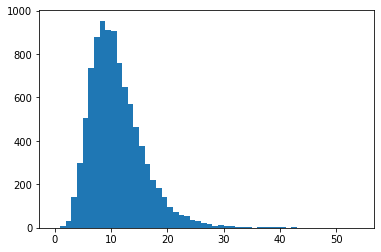

In [20]:
# setting max_len
# 1. first chekc distribution of sentences

len_distribution = [len(l.split()) for l in know_train[0]['text_response']]

print(f"max: {max(len_distribution)}")
print(f"mean: {np.mean(len_distribution)}")
plt.hist(len_distribution, bins = np.arange(0,55,1))
plt.show()

In [21]:
vocab_size = len(ftmodel.wv.vectors) + 1
max_len = 20

def seq_padding(seq, max_len):
    if len(seq) < max_len:
        n = max_len - len(seq)
        zero_list = [0] * n
        seq += zero_list
    elif len(seq) > max_len:
        seq = seq[:max_len] 
    
    return seq   

In [22]:
embedding_matrix = np.zeros((ftmodel.wv.vectors.shape[0]+1, ftmodel.wv.vectors.shape[1]))
for i in range(len(ftmodel.wv.vectors)):
    embedding_matrix[i+1] = ftmodel.wv.vectors[i]

np.shape(embedding_matrix)

(6569, 20)

In [23]:
X1_train = np.array(X_train['text_response'].apply(lambda sen : seq_padding(sen_to_seq(sen.split()), max_len)).to_list())
X1_val = np.array(X_val['text_response'].apply(lambda sen : seq_padding(sen_to_seq(sen.split()), max_len)).to_list())

print(X1_train.shape)
print(X1_val.shape)

(7588, 20)
(1898, 20)


In [24]:
# X2 변수에 대해서 행렬로 바꿔줍니다(Numeric)

X2_train = X_train[X_train.columns.difference(['text_response'])].values
X2_val = X_val[X_val.columns.difference(['text_response'])].values

num_col_len = X2_train.shape[1]
print('X2 변수의 train shape :',X2_train.shape,'(칼럼은',num_col_len,'으로 이따가 input2으로 들어가야 하므로 기억해둡시다)')
print('X2 변수의 test shape :',X2_val.shape)

X2 변수의 train shape : (7588, 147) (칼럼은 147 으로 이따가 input2으로 들어가야 하므로 기억해둡시다)
X2 변수의 test shape : (1898, 147)


In [25]:
import tensorflow as tf
tf.random.set_seed(RANDOM_STATE)

# GPU를 사용해서 학습해봐요
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
# 두가지 input을 받는 모델입니다
input_1 = Input(shape=(max_len,))    # X1 변수가 이리로 들어가야 합니다. 때문에 칼럼을 maxlen으로 맞춰줍니다
input_2 = Input(shape=(num_col_len,)) # X2 변수가 이리로 들어가야 합니다. 때문에 칼럼을 num_col_len 맞춰줍니다

In [27]:
# Text Dense
embedding_layer = Embedding(vocab_size, word_dim, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer = LSTM(32)(embedding_layer)
batch_layer = BatchNormalization()(LSTM_Layer)

# Numeric Dens
dense_layer_1 = Dense(16, activation='relu')(input_2)
dropout = Dropout(0.5)(dense_layer_1)

concat_layer = Concatenate()([batch_layer, dropout])
output = Dense(len_output, activation='softmax')(concat_layer)

# model 만들기
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 20)       131380      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 147)]        0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 32)           6784        ['embedding[0][0]']              
                                                                                              

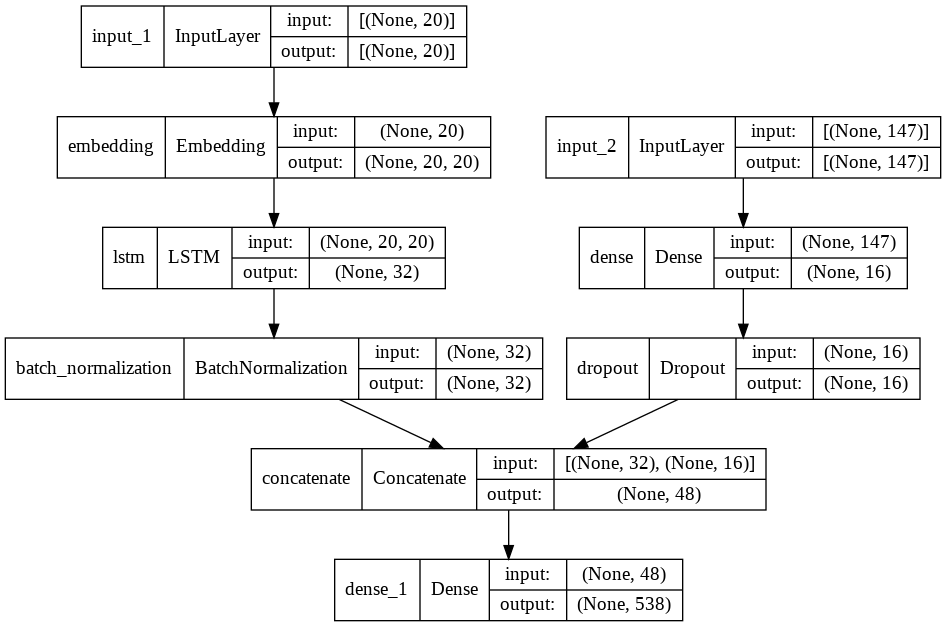

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [29]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.2)

Epoch 1/200
48/48 [==============================] - 4s 24ms/step - loss: 309.0610 - acc: 0.0033 - val_loss: 107.8753 - val_acc: 0.0066
Epoch 2/200
48/48 [==============================] - 1s 11ms/step - loss: 120.7284 - acc: 0.0054 - val_loss: 45.8590 - val_acc: 0.0204
Epoch 3/200
48/48 [==============================] - 1s 13ms/step - loss: 45.7901 - acc: 0.0092 - val_loss: 18.6299 - val_acc: 0.0171
Epoch 4/200
48/48 [==============================] - 1s 13ms/step - loss: 14.1573 - acc: 0.0318 - val_loss: 7.9417 - val_acc: 0.0316
Epoch 5/200
48/48 [==============================] - 1s 11ms/step - loss: 6.4359 - acc: 0.0425 - val_loss: 5.9227 - val_acc: 0.0382
Epoch 6/200
48/48 [==============================] - 1s 13ms/step - loss: 5.4303 - acc: 0.0563 - val_loss: 5.6141 - val_acc: 0.0448
Epoch 7/200
48/48 [==============================] - 1s 11ms/step - loss: 5.2530 - acc: 0.0666 - val_loss: 5.3987 - val_acc: 0.0487
Epoch 8/200
48/48 [==============================] - 1s 11ms/step 

In [30]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

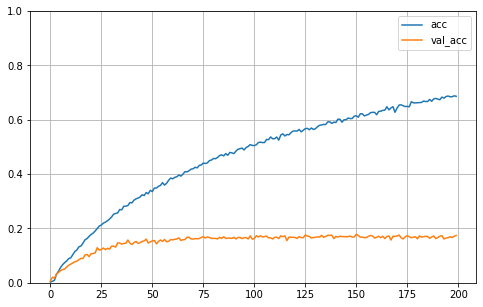

In [31]:
pd.DataFrame(history.history)[['acc', 'val_acc']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.0)
plt.show()

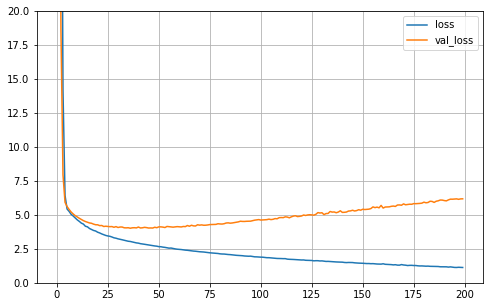

In [32]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 20)
plt.show()